In [1]:
from looti import cosmo_emulator as cem
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle

Load trained emulators

In [ ]:
pd.read_csv('../training_data/class_Asw0wa_DP_cmb_2K_EE.csv.zip', index_col=list(range(18)))

In [ ]:
Looti = cem.CosmoEmulator(external_info={'config_yaml': '../readfile_configs/read_input4cast.yaml'})

In [ ]:
Looti.FileReader.__dict__.keys()

In [ ]:
Looti.create_dataframes()

Set all parameters for training

In [2]:
# path and file name of the training data set (pandas dataframe)
data_path = '../training_data/'
file_name = 'class_Asw0wa_DP_cmb_2K_TT'

# type of observable to be emulated
cosmo_quantity = 'TT'

# number of varying parameters in data set
n_params = 8

# set size of training and test data set
n_train = 575
n_test = 10

# choose redshifts
redshifts = [0]

# choose if during training the logarithm of the grid and spectrum should be used
features_to_Log = False
observable_to_Log = False

# choose number of PCA components
ncomp = 15

# option to have a seperate Gaussian process for each PCA component
mult_gp = True

In [3]:
external_info = {'config_yaml': '../readfile_configs/read_input4cast.yaml'}

Initialize Emulator

In [4]:
LootiEmu_pk = cem.CosmoEmulator(external_info=external_info)

Read the pandas data frame, perform seperation into training and test sets, and normalize data

In [5]:
LootiEmu_pk.read_data(cosmo_quantity=cosmo_quantity, 
                      data_path=data_path, 
                      file_name=file_name, 
                      n_params=n_params, 
                      n_train=n_train, 
                      n_test=n_test,
                      redshifts=redshifts,
                      features_to_Log=features_to_Log,
                      observable_to_Log=observable_to_Log)

Training

In [6]:
LootiEmu_pk.create_emulator(cosmo_quantity=cosmo_quantity, 
                            n_params=n_params, 
                            mult_gp=mult_gp, 
                            ncomp=ncomp, 
                            gp_length=np.ones(n_params))

Access the data and the trained emulator

In [7]:
emulation_data_pk = LootiEmu_pk.data[cosmo_quantity]
intobj_pk = LootiEmu_pk.emu_objs[cosmo_quantity][0]

Check convergence by evaluating the emulator on the training dataset

In [8]:
# input parameters of training dataset
xtrain = intobj_pk.trainspace_normed

# target values of PCA components for the training dataset
truth_normed_pcas_train = intobj_pk.representation

if mult_gp == True:
    # get predicted values of PCA components and uncertainty of the prediction from each GP
    pred_temp = []
    std_temp = []
    for comp, gp in enumerate(intobj_pk.gp_dict.values()):
        predictioncomp_train_temp, std_pca_train_temp = gp.predict(xtrain, return_std=True)
        pred_temp.append(list(predictioncomp_train_temp))
        std_temp.append(list(std_pca_train_temp))

    # predicted values of PCA components for the training dataset
    predictioncomp_train = np.array(pred_temp).T

    # standard deviations of all predictions for the training dataset
    std_pca_train = np.array(std_temp).T
    
else:
    # get prediction of values for all PCA component from GP
    predictioncomp_train, std_pca_train = intobj_pk.gp_regressor.predict(xtrain, return_std=True)

Plot the residuals (target minus predicted values of PCA components) for a small subset of the training dataset

In [9]:
# looking at first 10 samples from training dataset
n_plot_train = 10

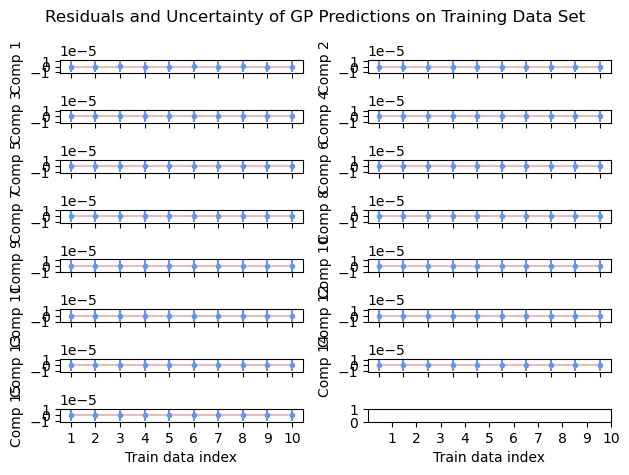

In [10]:
pca_grid = np.linspace(1, n_plot_train, n_plot_train)
fig, axs = plt.subplots(nrows=int(np.ceil(ncomp/2)), ncols=2)

fig.suptitle('Residuals and Uncertainty of GP Predictions on Training Data Set')

for comp in range(ncomp):
    axs.ravel()[comp].errorbar(pca_grid, 
                 truth_normed_pcas_train[:n_plot_train][:,comp]-predictioncomp_train[:n_plot_train][:,comp], 
                 yerr=std_pca_train[:n_plot_train][:,comp], 
                 linestyle='', marker='.', color='cornflowerblue')
    axs.ravel()[comp].hlines(0, 1, n_plot_train, color='firebrick', alpha=0.3)

    axs.ravel()[comp].set_ylabel("Comp %i" %(comp+1))
    axs.ravel()[comp].set_xticks(list(range(1,n_plot_train+1)))
    axs.ravel()[comp].set_xticklabels([])

for i in range(2):
    axs[-1, i].set_xlabel('Train data index')
    axs[-1, i].set_xticks(list(range(1, n_plot_train+1)))
    axs[-1, i].set_xticklabels(list(range(1, n_plot_train+1)))

plt.tight_layout()
plt.show()

Evaluate the emulator on the test dataset

In [11]:
xtest = (emulation_data_pk.test_samples - intobj_pk.trainspace_mean) / intobj_pk.trainspace_std

if mult_gp == True:
    pred_temp = []
    std_temp = []
    for comp, gp in enumerate(intobj_pk.gp_dict.values()):
        predictioncomp_test_temp, std_pca_test_temp = gp.predict(xtest, return_std=True)
        pred_temp.append(list(predictioncomp_test_temp))
        std_temp.append(list(std_pca_test_temp))
        
    predictioncomp_test = np.array(pred_temp).T
    std_pca_test = np.array(std_temp).T
    
else:
    predictioncomp_test, std_pca_test = intobj_pk.gp_regressor.predict(xtest, return_std=True)

Perform PCA on the test data to get target values for all PCA components

In [12]:
nparam = emulation_data_pk.num_parameters + int(emulation_data_pk.multiple_z)
if emulation_data_pk.multiple_z:
    params = ['z']
else:
    params = []
params += list(emulation_data_pk.paramnames_dict.values())

truth_normed_pcas_list = []
for ii in range(emulation_data_pk.test_samples.shape[0]):
    indexvalues = emulation_data_pk.test_samples[ii]
    if emulation_data_pk.multiple_z:
        index_list = emulation_data_pk.data_type, indexvalues[0], params[1], indexvalues[1], params[2], indexvalues[2], params[3], indexvalues[3], params[4], indexvalues[4], params[5], indexvalues[5]
    else:
        index_list = emulation_data_pk.data_type, 0.0, params[0], indexvalues[0], params[1], indexvalues[1], params[2], indexvalues[2], params[3], indexvalues[3], params[4], indexvalues[4], params[5], indexvalues[5]

    truth_spectrum_test = emulation_data_pk.df_ext.loc[index_list].values.flatten()
    ref_spectrum = emulation_data_pk.df_ref.loc[emulation_data_pk.data_type, 0.0].values.flatten()

    truth_spectrum_normed_test = ((truth_spectrum_test/ref_spectrum) - emulation_data_pk.binwise_mean) / emulation_data_pk.binwise_std
    truth_pca_test_raw = intobj_pk.pca.transform([truth_spectrum_normed_test]).flatten()
    truth_pca_test = (truth_pca_test_raw - intobj_pk.matPCA_mean) / intobj_pk.matPCA_std
    truth_normed_pcas_list.append(truth_pca_test)

truth_normed_pcas = np.array(truth_normed_pcas_list)

Plot the residuals (target minus predicted values of PCA components) for the test dataset

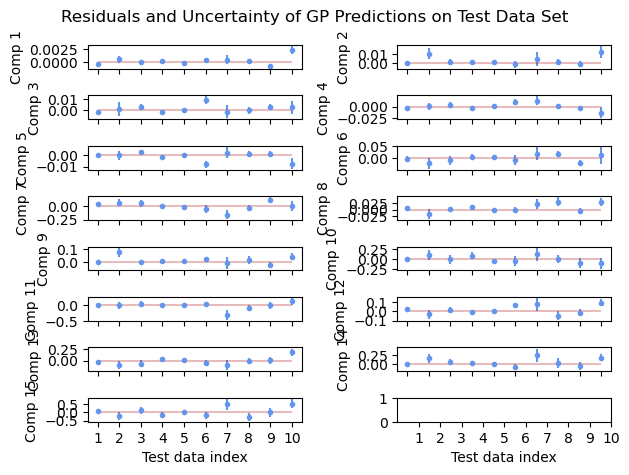

In [13]:
n_test = len(emulation_data_pk.test_samples)
pca_grid = np.linspace(1, n_test, n_test)
fig, axs = plt.subplots(nrows=int(np.ceil(ncomp/2)), ncols=2)

fig.suptitle('Residuals and Uncertainty of GP Predictions on Test Data Set')

for comp in range(ncomp):
    axs.ravel()[comp].errorbar(pca_grid, 
                 truth_normed_pcas[:,comp]-predictioncomp_test[:,comp], 
                 yerr=std_pca_test[:,comp], 
                 linestyle='', marker='.', color='cornflowerblue')
    axs.ravel()[comp].hlines(0, 1, n_test, color='firebrick', alpha=0.3)

    axs.ravel()[comp].set_ylabel("Comp %i" %(comp+1))
    axs.ravel()[comp].set_xticks(list(range(1,n_test+1)))
    axs.ravel()[comp].set_xticklabels([])

for i in range(2):
    axs[-1, i].set_xlabel('Test data index')
    axs[-1, i].set_xticks(list(range(1, n_test+1)))
    axs[-1, i].set_xticklabels(list(range(1, n_test+1)))

plt.tight_layout()
plt.show()

Plot the predicted vs. true spectra, and the residuals

In [14]:
LootiEmu_pk.get_params(cosmo_quantity=cosmo_quantity)

{'w0_fld': (-1.2082847236019565, -0.7784777665320629),
 'wa_fld': (-0.223209646259207, 0.218436238638729),
 'Omega_m': (0.2475442310718172, 0.3801960455776076),
 'Omega_b': (0.0391880619153169, 0.0595442366749061),
 'h': (0.5235714224216692, 0.8069503525109054),
 'n_s': (0.7648461799885335, 1.1722584415156203),
 'A_s': (1.6805158479988954e-09, 2.547547147458293e-09),
 'sigma8': (0.5693616092184647, 1.1059196285223656)}

In [15]:
emulation_data_pk.df_ext

1  \
data_type redshift parameter_1 parameter_1_value parameter_2 parameter_2_value parameter_3 parameter_3_value parameter_4 parameter_4_value parameter_5 parameter_5_value parameter_6 parameter_6_value parameter_7 parameter_7_value parameter_8 parameter_8_value        
TT        0.0      w0_fld      -1.208285         wa_fld       0.029773         Omega_m     0.328389          Omega_b     0.045162          h           0.734991          n_s         0.963008          A_s         2.132116e-09      sigma8      0.991070           0.0   
                               -1.203346         wa_fld       0.005401         Omega_m     0.325453          Omega_b     0.046907          h           0.658028          n_s         0.995601          A_s         2.238159e-09      sigma8      0.891390           0.0   
                               -1.201060         wa_fld       0.018068         Omega_m     0.303582          Omega_b     0.050296          h           0.625566          n_s         0.978612          A_s         1.991990e-09      sigma8      0.732962           0.0   
                               -1.198195         wa_fld       0.016307         Omega_m     0.297086          Omega_b     0.052457          h           0.630181          n_s         0.955103          A_s         2.169081e-09      sigma8      0.742599           0.0   
                               -1.196515         wa_fld      -0.079891         Omega_m     0.315406          Omega_b     0.045148          h           0.642063          n_s         0.927319          A_s         2.245376e-09      sigma8      0.839153           0.0   
...                                                                                                                                                                                                                                                                 ...   
                               -0.799659         wa_fld      -0.016342         Omega_m     0.310673          Omega_b     0.044887          h           0.647364          n_s         0.960367          A_s         2.115883e-09      sigma8      0.741849           0.0   
                               -0.793162         wa_fld       0.072630         Omega_m     0.312269          Omega_b     0.050606          h           0.622519          n_s         1.043414          A_s         2.165361e-09      sigma8      0.703928           0.0   
                               -0.783278         wa_fld      -0.068577         Omega_m     0.298533          Omega_b     0.049307          h           0.726483          n_s         0.988951          A_s         2.028682e-09      sigma8      0.791111           0.0   
                               -0.778478         wa_fld      -0.055895         Omega_m     0.300990          Omega_b     0.049642          h           0.644927          n_s         0.981072          A_s         2.113426e-09      sigma8      0.701547           0.0   
grid      NaN      NaN         NaN               NaN         NaN               NaN         NaN               NaN         NaN               NaN         NaN               NaN         NaN               NaN         NaN               NaN         NaN                0.0   

                                                                                                                                                                                                                                                                      2  \
data_type redshift parameter_1 parameter_1_value parameter_2 parameter_2_value parameter_3 parameter_3_value parameter_4 parameter_4_value parameter_5 parameter_5_value parameter_6 parameter_6_value parameter_7 parameter_7_value parameter_8 parameter_8_value        
TT        0.0      w0_fld      -1.208285         wa_fld       0.029773         Omega_m     0.328389          Omega_b     0.045162          h           0.734991          n_s         0.963008          A_s         2.132116e-09      sigma8      0.991070       

GRID: (2511,)


AttributeError: 'list' object has no attribute 'shape'

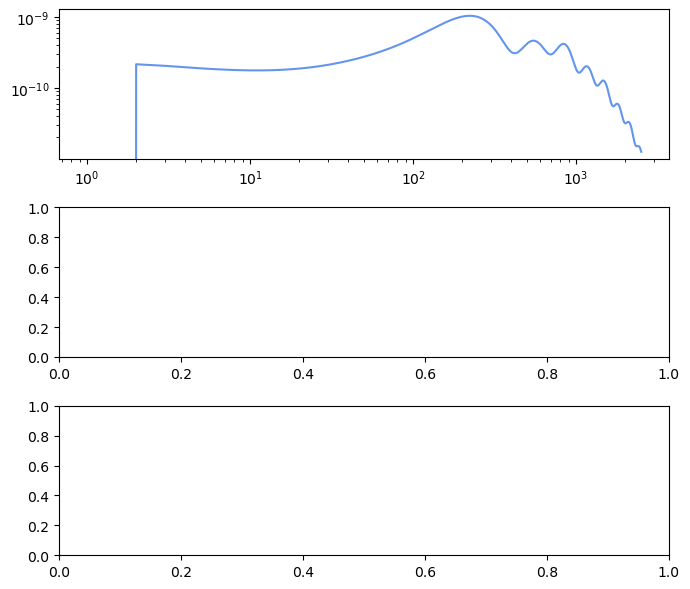

In [18]:
colors = plt.cm.coolwarm(np.linspace(0, 1, len(emulation_data_pk.test_samples)))
fig, ax =plt.subplots(3, figsize=(7, 6))
fig.set_tight_layout(tight=True)

# get a list of the varying parameters
params_varying = list(LootiEmu_pk.get_params(cosmo_quantity=cosmo_quantity).keys())

# get true target spectra of the test dataset
test_indices = emulation_data_pk.test_splitdict[0]
truth_spectrum = emulation_data_pk.df_ext.loc[cosmo_quantity].values[test_indices]

for plot_index, color in enumerate(colors):
    # create input dictionary with values of test sample for each parameter
    input_values = emulation_data_pk.test_samples[plot_index]
    input_dict_pk = dict()
    for param, value in zip(params_varying, input_values):
        input_dict_pk[param] = value

    # get the grid and the predicted spectrum for the given input
    z_grid, grid_temp, pk_test = LootiEmu_pk.get_prediction(cosmo_quantity=cosmo_quantity, input_dict=input_dict_pk)

    # transform grid in case it is given logarithmically
    if features_to_Log==True:
        grid = np.power(10, grid_temp)
    else:
        grid = grid_temp

    # get the target spectra for current index in test dataset
    pk_truth = truth_spectrum[plot_index]

    # upper plot: target and predicted spectrum 
    ax[0].loglog(grid, pk_truth, c='cornflowerblue', label='truth')
    ax[0].loglog(grid, pk_test, c='firebrick', linestyle='--', label='prediction')

    # middle plot: relative residuals
    residuals = 1 - pk_test / truth_spectrum[plot_index]
    ax[1].semilogx(grid, residuals, color=color)

    # lower plot: absolute residuals
    residuals = pk_test - truth_spectrum[plot_index]
    ax[2].semilogx(grid, residuals, color=color)

# set lables and title
ax[0].set_title('Prediction and Residuals for %i test samples' %(len(emulation_data_pk.test_samples)))
ax[0].set_ylabel('Spectra')
ax[0].set_xticklabels([])
ax[1].set_ylabel('Relative Residuals')
ax[1].set_xticklabels([])
ax[2].set_xlabel(r'$k$')
ax[2].set_ylabel('Residuals')

plt.tight_layout()
plt.show()

Chose path and file name to save trained emulator and dataset

In [ ]:
save_path = '../emulators/'
save_name = cosmo_quantity

Save emulator and dataset

In [ ]:
pickle.dump(emulation_data_pk, open(save_path+save_name+'test_data.sav', 'wb'))
pickle.dump(intobj_pk, open(save_path+save_name+'test.sav', 'wb'))